# Direct Regression

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
import pickle
import time
from reed import drop_missing_treatment_or_outcome, Model, transform_outcome

# set global notebook options
pd.options.display.max_columns = 200
pd.options.display.max_rows = 500
pd.options.display.max_colwidth = 100

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Response Model

How well can we predict outcomes $Y$ conditional on treatment $T$ and other covariates $Z$?

### Treatent variables

   - **reduhl**	Completed re-education based on highest level of attainment
   - **redudl**	Completed re-education based on detailed qualifications
   - **redufl**	Completed re-education using highest lvl and detailed qualifications.

### Outcome variables
   - Mental health in 2019 (**mh**). This is the transformed mental health scores from the aggregation of mental health items of the SF-36 Health Survey, as reported by the individual in 2019. It ranges from 0 to 100, with higher scores indicating better mental health.  
   - Working hours in 2019 (**wkhr**) records the total number of hours the individual works in all jobs in a week on average. Working hours are set to 0 for those not working. 
   - Hourly Wages in 2019 (**rlwage**) records the average hourly wage for the individual’s main job in 2019. Hourly wages are set to 0 for those not working and set to missing for those reporting working more than 100 hours a week. 
   
#### Columns explicitly excluded
   - **xwaveid** (unique identifier)
   - **p_rcom*** (timing of completion of re-education, proxies treatment) TODO think about how we would include this
   - **p_cotrl** (first avail 2003)
   - **p_rdf*** (first avail 2012)
   
### (Nested) cross-validate to evaluate model performance
![image.png](images/nested_cross_val.png)

### Bootstraped cross-validation to estimate parameter uncertainty
![image.png](images/bootstrap_validation.png)

#### Parameters

In [2]:
optimisation_metric = 'neg_mean_squared_error'
evaluation_metrics = ('r2','neg_mean_squared_error')
log_outcome=True
standardize_outcome=True
load_from_cache=False
exclude_patterns = [
    '^reduhl$', '^rehllt$', '^redudl$', '^redufl$', '^redllt$', '^refllt$',
    '^rlwage$', '^mh$', '^mhbm$', '^wkhr$', '^y_', '^p_rcom','^p_rdf','^p_cotrl',
    '^xwaveid$','p_rcom18','^aedcq', '^abnfsty','^aedcqfpt','^aedqstdy'
]
data_load_func = lambda filepath: pd.read_csv(filepath, index_col='xwaveid')

configuration_name = 'default'
outcome = 'y_wsce'#'y_wsce'
treatment = 'redufl'
test=True
data_file = "data/all_lasso_selected_100.csv"

In [3]:
# Parameters
configuration_name = "lasso-100"
outcome = "y_wsce"
treatment = "redufl"
test = False
data_file = "data/all_lasso_selected_100.csv"


In [4]:
# parameters that depend on those set above (which may have been inserted by Papermill)
if test:
    inner_cv = 2
    outer_cv = 2
    bootstrap_samples = 3

else:
    inner_cv = 5
    outer_cv = 10
    bootstrap_samples = 50

cross_val_cache = f"data/cross-val-{configuration_name}.pkl"#"data/cross-val-all.pkl"
bootstrap_cache = f"data/bootstrap-{configuration_name}.pkl"#"data/bootstrap-all.pkl"

### Load Data 
   - drop rows missing the specified treatment or outcome

Dropped 284 rows missing treatment or outcome.


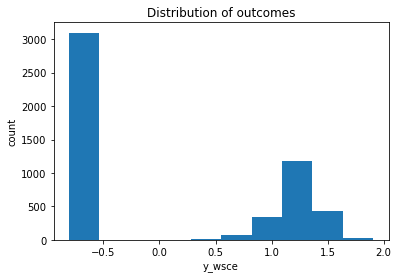

In [5]:
data = data_load_func(data_file)
drop_missing_treatment_or_outcome(data, treatment, outcome)
data[outcome] = transform_outcome(data[outcome],log_outcome, standardize_outcome)

    
plt.hist(data[outcome])
plt.xlabel(outcome)
plt.ylabel("count")
plt.title("Distribution of outcomes");

### Set up models
Specify which models to use and the hyper-parameter space to search over for each

In [6]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from direct_regression import importance_from_coef

def construct_models():
    models = [
        Model('ridge',Ridge(), 
              parameters = {
                  'alpha':np.logspace(-1,4,30)
              },
              importance_func=importance_from_coef
        ),
        Model('lasso',Lasso(),
              parameters = {
                  'alpha':np.logspace(-2,4,30)
              },
              importance_func=importance_from_coef
        ), 
        Model('gbr',GradientBoostingRegressor(n_iter_no_change=20, max_depth=2),
              parameters = {
                'max_features':np.linspace(0,1,6)[1:],
                'learning_rate':np.logspace(-3,0,10),
                'min_samples_leaf':np.logspace(0,3,10).astype(int)
              }
        ),
    ]
    return models

# used for quick tests
def construct_test_models(): 
    models = [
        Model('Ridge',Ridge(),
              parameters = {'alpha':np.logspace(1,4,2)},
              importance_func=importance_from_coef
        ),
        Model('gbr',GradientBoostingRegressor(n_iter_no_change=20, max_depth=2),
              parameters = {
                'max_features':np.linspace(0,1,4)[1:],
              }
        ),
    ]
    return models

model_init = construct_test_models if test else construct_models

### Prepare data for modeling
   - split into treated/control
   - impute missing values and scale
   - separate features from outcomes&treatments

In [7]:
from direct_regression import seperate_and_transform_data
X0, X1, y0, y1, X, y, t, features = seperate_and_transform_data(data, treatment, outcome)
print("Control data dimensions: ",X0.shape)
print("Treated data dimensions:",X1.shape)

Control data dimensions:  (3789, 104)
Treated data dimensions: (1368, 104)


### Compute unconditional/unadjusted estimate of treatment effect

In [8]:
from direct_regression import print_unconditional_effects
print_unconditional_effects(data, treatment, y0, y1)

Proportion Treated:27%
Average outcome under Control:-0.14±0.02
Average outcome under Treatment:0.37±0.03
Unadjusted treatment estimate 0.51


### Propensity model

- Run primarily to check for violations over overlap assumptions.

In [9]:
from reed import visualise_propensity_model_performance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

X_train, X_test, t_train, t_test = train_test_split(X,t,stratify=t)
pmodel = LogisticRegressionCV(Cs = np.logspace(-5,-1,20), penalty='l2', max_iter=10000)
pmodel.fit(X_train, t_train);

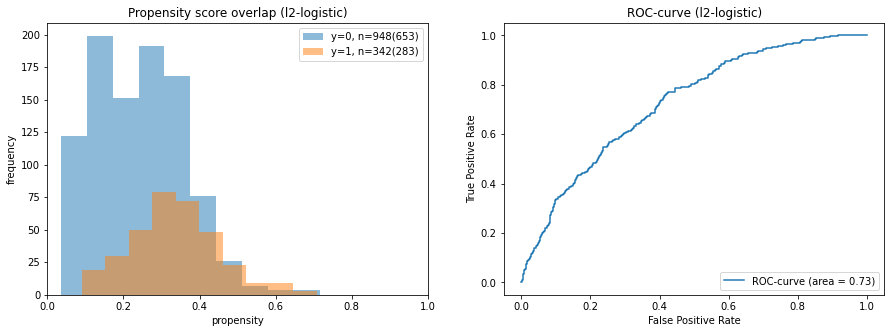

In [10]:
visualise_propensity_model_performance(t_test, pmodel.predict_proba(X_test)[:,1],'l2-logistic',bins=10)

In [11]:
def propensity_coefficients(model, features):
    if hasattr(model,'best_estimator_'):
        model = model.best_estimator_
    coef = model.coef_[0]
    
    with open('data/metadata.pkl','rb') as f:
        meta = pickle.load(f)
        labels = [meta.column_names_to_labels.get(f) for f in features]
    return pd.DataFrame({'label': labels, "c":coef,'abs':np.abs(coef)},index=features).sort_values(by='abs',ascending=False).head(50)
print("Propensity Model Coefficients")      
propensity_coefficients(pmodel, features).head(20)

Propensity Model Coefficients


,label,c,abs
ahgage1,DV: Age last birthday at June 30 2001 - person 01,-0.121894,0.121894
ahhyng,DV: Age of youngest person in household,-0.115656,0.115656
awscoef,DV: Imputation flag current weekly gross wages & salary - other jobs,0.103953,0.103953
atcnr,DV: Number of own non-resident children,-0.093035,0.093035
aehtjbyr,D3a1 Years in paid work,-0.091609,0.091609
ajbempt,DV: Tenure with current employer (years),-0.086182,0.086182
ahsyrcad,DV: Years at current address,-0.085532,0.085532
ajsl4wk,F1 Looked for work in last 4 weeks,0.080417,0.080417
aedhists,C2 Highest year of school completed/currently attending,-0.071846,0.071846
aloimpew,K8 Importance - B Your employment and work situation,0.061671,0.061671


In [12]:
from direct_regression import nested_cross_val

models0, models1, results = nested_cross_val(
    model_init,
    cross_val_cache,
    X0, X1, y0, y1,
    optimisation_metric,
    evaluation_metrics,
    innercv=inner_cv,
    outercv=outer_cv,
    load_from_cache=load_from_cache
)

Fitting ridge ...Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Done
Fitting lasso ...Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Done
Fitting gbr ...Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Done
Caching results to data/cross-val-lasso-100.pkl


### Report estimate ATE and model performance

  - Mean and Std of prediction performance for each model (both treatment & control surface)
  - Mean and Std of average treatment effect for each model

,ACE,ACE_std,control_r2,control_r2_std,treated_r2,treated_r2_std,control_neg_mean_squared_error,control_neg_mean_squared_error_std,treated_neg_mean_squared_error,treated_neg_mean_squared_error_std
ridge,0.17,0.01,0.37,0.03,0.19,0.03,-0.58,0.03,-0.82,0.04
lasso,0.17,0.02,0.37,0.03,0.18,0.06,-0.58,0.04,-0.83,0.06
gbr,0.15,0.03,0.44,0.03,0.24,0.04,-0.51,0.02,-0.77,0.05


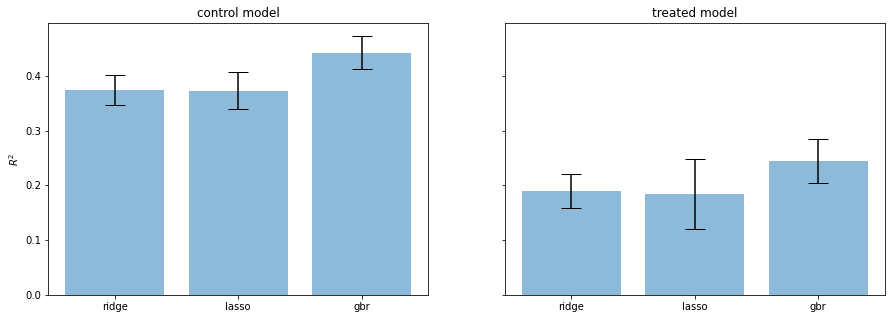

In [13]:
from direct_regression import visualise_ate
metrics, ate_vals = visualise_ate(results,X,evaluation_metrics);

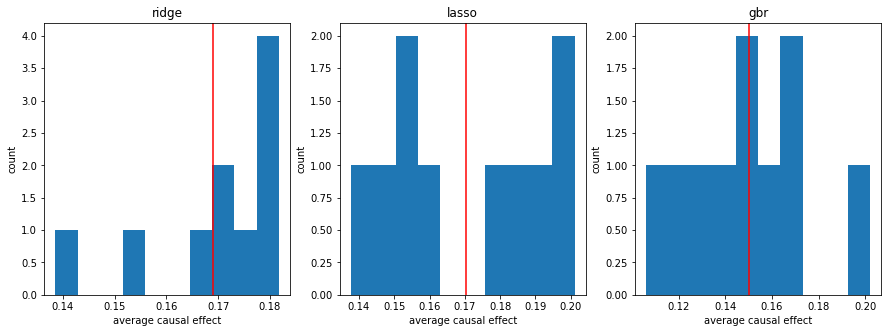

In [14]:
from direct_regression import plot_ate_distribution
plot_ate_distribution(ate_vals)

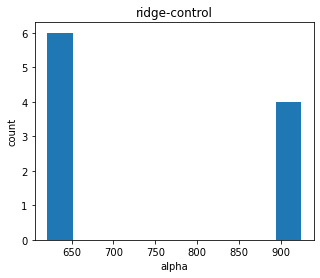

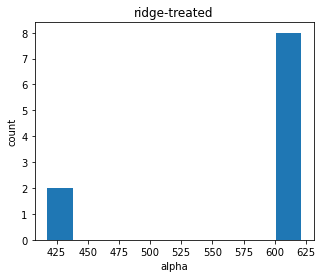

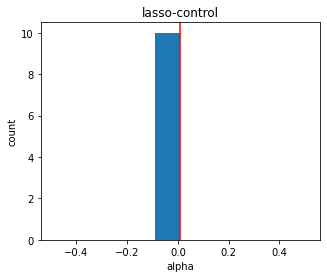

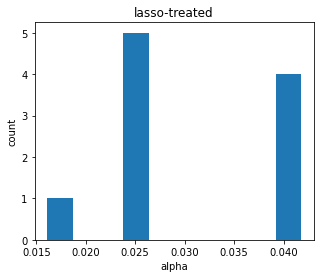

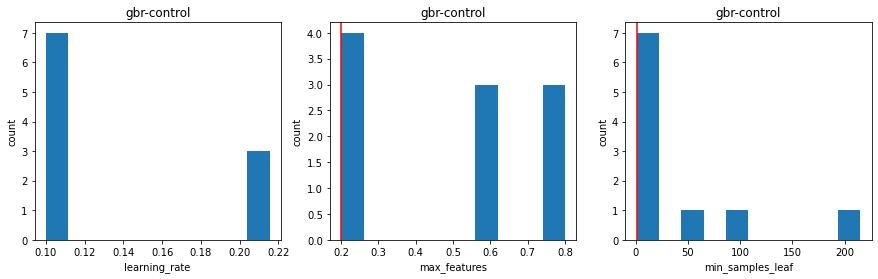

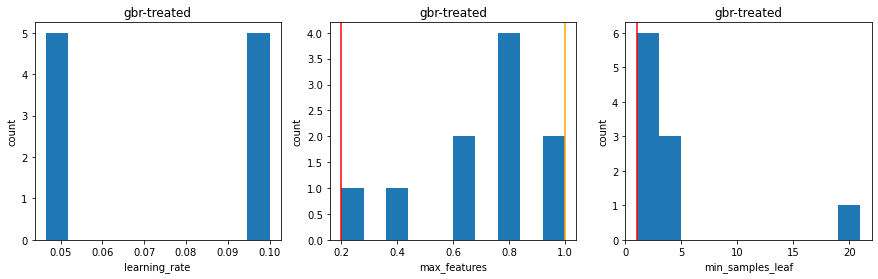

In [15]:
from direct_regression import plot_hyperparam_distributions
for model, (results0, results1) in results.items():
    plot_hyperparam_distributions(results0,f"{model}-control")
    plot_hyperparam_distributions(results1,f"{model}-treated")

### Visualise models
- Features responsible for treatment effect heterogeneity & functional form (with uncertainty)
      - coefficeints for linear models
      - TODO permutation importance & partial dependence curves for non-linear models

In [16]:
from direct_regression import display_feature_importance
display_feature_importance(models0, models1, results, features);

ridge


,importance_mean,importance_std,Δcoef_mean,Δcoef_std,coef_treat_mean,coef_treat_std,coef_cntr_mean,coef_cntr_std
feature,,,,,,,,
ahgage1,0.131054,0.005350,-0.004938,0.011956,-0.133523,0.009301,-0.128585,0.006498
atcnr,0.086291,0.004290,-0.026923,0.006011,-0.099752,0.006911,-0.072829,0.002668
aehtjbyr,0.085950,0.004374,-0.004540,0.002802,-0.088221,0.004958,-0.083680,0.004197
ahhyng,0.071604,0.004113,-0.010109,0.009516,-0.076659,0.008268,-0.066550,0.003280
ahh0_4,0.068575,0.002882,-0.014339,0.008038,0.061406,0.004519,0.075745,0.005338
ahsyrcad,0.061070,0.004136,0.003478,0.008017,-0.059330,0.006768,-0.062809,0.004533
ahhd5_9,0.052780,0.003353,-0.021954,0.006909,0.041803,0.005629,0.063757,0.003830
ahspown,0.049545,0.003322,0.004251,0.007667,0.051671,0.005740,0.047420,0.004303
agh3a,0.049059,0.002584,0.007027,0.009310,0.052573,0.004852,0.045546,0.005757


lasso


,importance_mean,importance_std,Δcoef_mean,Δcoef_std,coef_treat_mean,coef_treat_std,coef_cntr_mean,coef_cntr_std
feature,,,,,,,,
ahgage1,0.201645,0.011178,-0.048373,0.020034,-0.225832,0.019459,-0.177459,0.008483
atcnr,0.115346,0.010652,-0.075213,0.013169,-0.152952,0.016465,-0.077740,0.006525
aehtjbyr,0.083469,0.012645,-0.011840,0.018753,-0.089389,0.021536,-0.077549,0.005641
ahh0_4,0.064105,0.008020,-0.032206,0.017928,0.048003,0.015652,0.080208,0.006660
awscme,0.060221,0.004573,-0.117140,0.009180,0.001651,0.003081,0.118791,0.008629
ahifapti,0.056012,0.010246,0.004427,0.026382,-0.053798,0.022470,-0.058225,0.007286
agh3a,0.050845,0.007449,0.011282,0.008141,0.056486,0.010860,0.045204,0.005116
ahhyng,0.047898,0.008272,-0.002439,0.009189,-0.049118,0.010909,-0.046679,0.007751
ahsyrcad,0.043488,0.009299,0.030868,0.024768,-0.028053,0.021233,-0.058922,0.005372


### Compare against OLS on basic variables

In [17]:
basic = pd.read_csv("data/basic_variables.csv",index_col='xwaveid')
drop_missing_treatment_or_outcome(basic, treatment, outcome)
basic[outcome] = transform_outcome(basic[outcome],log_outcome, standardize_outcome)

    
X0b, X1b, y0b, y1b, Xb, yb, tb, featuresb = seperate_and_transform_data(basic, treatment, outcome)

def construct_basic_model():
    models = [
        Model('OLS',LinearRegression(),importance_func=importance_from_coef)
    ]
    return models

modelsb0, modelsb1, resultsb = nested_cross_val(
    construct_basic_model,
    "data/tmp.pkl",
    X0b, X1b, y0b, y1b,
    optimisation_metric,
    evaluation_metrics,
    innercv=inner_cv,
    outercv=outer_cv,
    load_from_cache=False)

Dropped 284 rows missing treatment or outcome.
Fitting OLS ...Done
Caching results to data/tmp.pkl


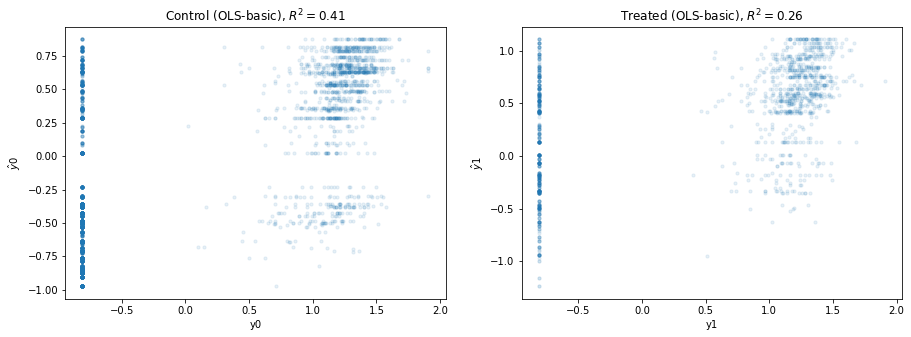

In [18]:
from sklearn.metrics import r2_score
y0b = resultsb['OLS'][0]['estimator'][0].predict(X0b)
y1b = resultsb['OLS'][1]['estimator'][0].predict(X1b)
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].scatter(y0, y0b,s=10,alpha=0.1)
ax[0].set_xlabel('y0')
ax[0].set_ylabel('$\\hat{y}0$');
ax[0].set_title(f'Control (OLS-basic), $R^2={r2_score(y0,y0b):.2f}$')

ax[1].scatter(y1, y1b,s=10,alpha=0.1)
ax[1].set_xlabel('y1')
ax[1].set_ylabel('$\\hat{y}1$');
ax[1].set_title(f'Treated (OLS-basic), $R^2={r2_score(y1,y1b):.2f}$');


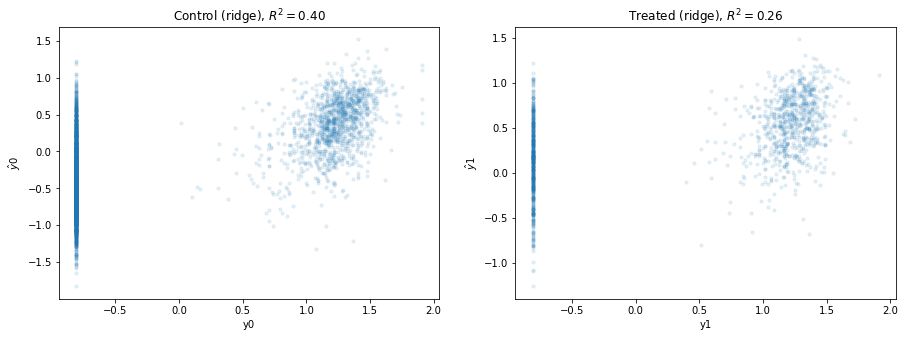

In [19]:
if 'ridge' in results.keys():
    y0a = results['ridge'][0]['estimator'][4].predict(X0)
    y1a = results['ridge'][1]['estimator'][4].predict(X1)
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    ax[0].scatter(y0, y0a,s=10,alpha=0.1)
    ax[0].set_xlabel('y0')
    ax[0].set_ylabel('$\\hat{y}0$');
    ax[0].set_title(f'Control (ridge), $R^2={r2_score(y0,y0a):.2f}$')

    ax[1].scatter(y1, y1a,s=10,alpha=0.1)
    ax[1].set_xlabel('y1')
    ax[1].set_ylabel('$\\hat{y}1$');
    ax[1].set_title(f'Treated (ridge), $R^2={r2_score(y1,y1a):.2f}$');

# think about why these r2 scores are higher than on the holdout set (and whether they are likely overfitting)
# despite there being so few variables

In [20]:
from direct_regression import bootstrapped_cross_val
def extract_params(estimator):
    return estimator.coef_


bootstrap_results = bootstrapped_cross_val(
    model_init,
    bootstrap_cache,
    X0, X1, y0, y1,
    optimisation_metric,
    extract_params,
    inner_cv=inner_cv,
    load_from_cache=load_from_cache,
    samples=bootstrap_samples
)

Fitting ridge ...Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Done
Fitting lasso ...Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Done
Fitting gbr ...Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Fitting 5 folds for each of 500 candidates, totalling 2500 fits


Done
Total time:15016.463990211487 seconds
Caching results to: data/bootstrap-lasso-100.pkl


####  Average treatment effects

In [21]:
from direct_regression import compute_ate
metrics, tau_estimatesb = compute_ate(bootstrap_results,X)
metrics

,ACE,ACE_std
ridge,0.189699,0.033151
lasso,0.185347,0.035161
gbr,0.156002,0.033737


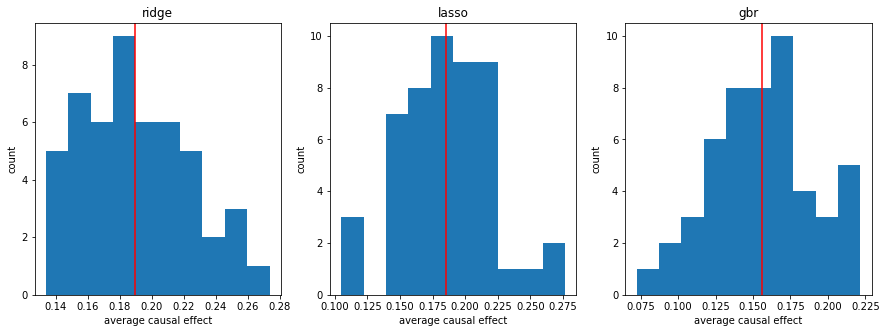

In [22]:
plot_ate_distribution(tau_estimatesb)

#### Distribution of hyper-parameters

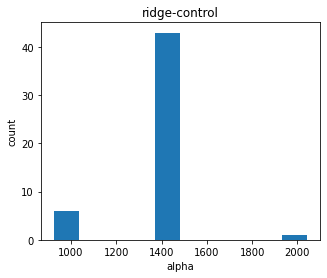

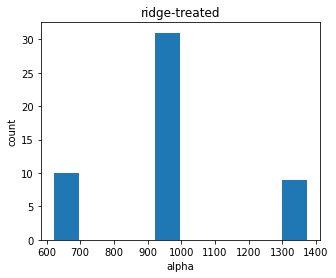

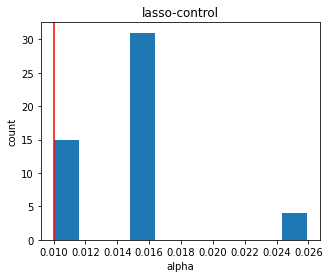

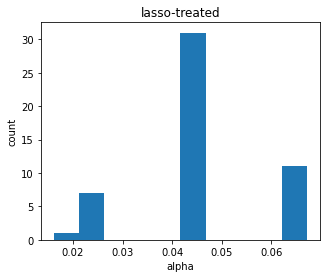

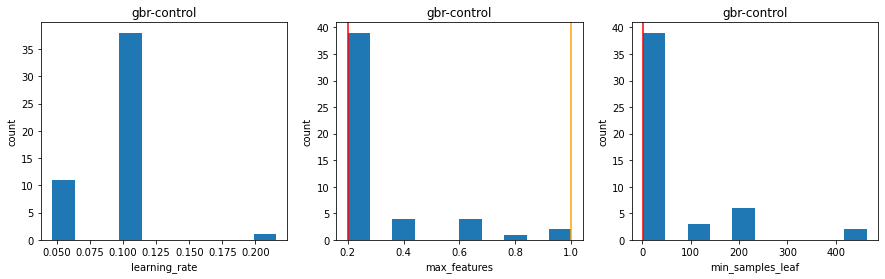

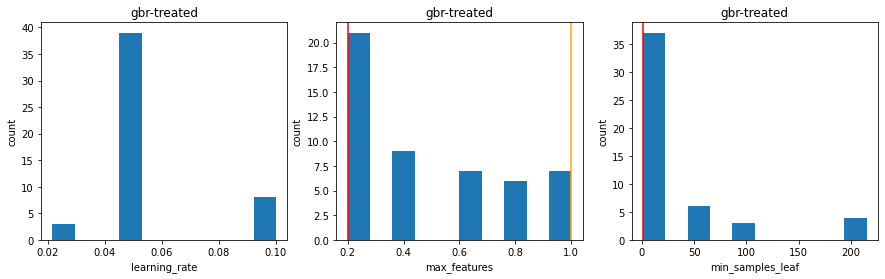

In [23]:
from direct_regression import plot_hyperparam_distributions
for model, (results0, results1) in bootstrap_results.items():
    plot_hyperparam_distributions(results0,f"{model}-control")
    plot_hyperparam_distributions(results1,f"{model}-treated")